# Organize ML projects with Scikit-Learn

While Machine Learning is powerful, people often overestimate it: apply machine learning to your project, and all your problems will be solved. In reality, it's not this simple. To be effective, one needs to organize the work very well. In this notebook, we will walkthrough practical aspects of a ML project. To look at the big picture, let's start with a checklist below. It should work reasonably well for most ML projects, but make sure to adapt it to your needs:

1. **Define the scope of work and objective**
    * How is your solution be used?
    * How should performance be measured? Are there any contraints?
    * How would the problem be solved manually?
    * List the available assumptions, and verify if possible.
    
    
2. **Get the data**
    * Document where you can get that data
    * Store data in a workspace you can easily access
    * Convert the data to a format you can easily manipulate
    * Check the overview (size, type, sample, description, statistics)
    * Data cleaning
    
    
3. **EDA & Data transformation**
    * Study each attribute and its characteristics (missing values, type of distribution, usefulness)
    * Visualize the data
    * Study the correlations between attributes
    * Feature selection, Feature Engineering, Feature scaling
    * Write functions for all data transformations
    
    
4. **Train models**
    * Automate as much as possible
    * Train promising models quickly using standard parameters. Measure and compare their performance
    * Analyze the errors the models make
    * Shortlist the top three of five most promising models, preferring models that make different types of errors.


5. **Fine-tunning**
    * Treat data transformation choices as hyperparameters, expecially when you are not sure about them (e.g., replace missing values with zeros or with the median value)
    * Unless there are very few hyperparameter value to explore, prefer random search over grid search.
    * Try ensemble methods
    * Test your final model on the test set to estimate the generalizaiton error. Don't tweak your model again, you would start overfitting the test set.

## Example: Articles categorization

### Objectives

Build a model to determine the categories of articles. 

### Get Data

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
bbc = pd.read_csv('https://raw.githubusercontent.com/dhminh1024/practice_datasets/master/bbc-text.csv')

In [ ]:
bbc.sample(5)

,category,text
1683,business,five million germans out of work germany s une...
700,politics,blunkett unveils policing plans people could b...
1808,sport,dal maso in to replace bergamasco david dal ma...
514,tech,net regulation still possible the blurring o...
1640,tech,blog picked as word of the year the term blo...


In [ ]:
bbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [ ]:
bbc.isnull().sum()

category    0
text        0
dtype: int64

**EDA** 

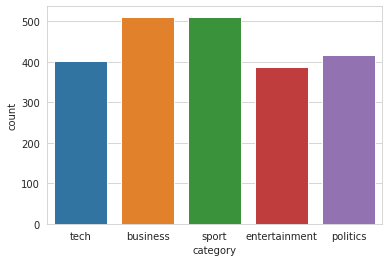

In [ ]:
# Your code here
bbc['category'].value_counts()
sns.countplot(bbc['category'])

In [ ]:
bbc['text length'] = bbc['text'].apply(lambda x: len(x.split()))

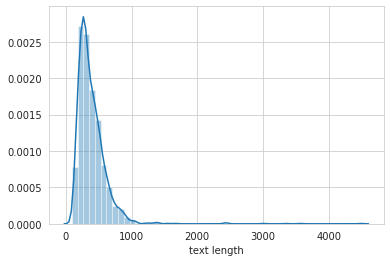

In [ ]:
sns.distplot(bbc['text length'],bins =50)

Prepare data for training

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Removing special characters and "trash"
import re
def preprocessor(text):
    text = text.lower()
    # Remove HTML markup
    text = re.sub('<[^>]>','',text)
    
    # Save emoticons for later appending
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)    
    # Remove any non-word character and append the emoticons,
    # removing the nose character for standarization. Convert to lower case
    # Your code here
    text = (re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-', ''))
   
    return text

In [ ]:

# tokenizer and stemming
# tokenizer: to break down our twits in individual words
# stemming: reducing a word to its root
from nltk.stem import PorterStemmer
# Your code here
porter = PorterStemmer()
def tokenizer_porter(text):
    return ' '.join([porter.stem(word) for word in text.split()]) # Your code here

In [ ]:
bbc['text'].apply(tokenizer_porter)

0       tv futur in the hand of viewer with home theat...
1       worldcom boss left book alon former worldcom b...
2       tiger wari of farrel gambl leicest say they wi...
3       yead face newcastl in fa cup premiership side ...
4       ocean s twelv raid box offic ocean s twelv the...
                              ...                        
2220    car pull down us retail figur us retail sale f...
2221    kilroy unveil immigr polici ex-chatshow host r...
2222    rem announc new glasgow concert us band rem ha...
2223    how polit squabbl snowbal it s becom commonpla...
2224    souness delight at euro progress boss graem so...
Name: text, Length: 2225, dtype: object

In [ ]:
bbc['text'].apply(tokenizer_porter)

0       tv futur in the hand of viewer with home theat...
1       worldcom boss left book alon former worldcom b...
2       tiger wari of farrel gambl leicest say they wi...
3       yead face newcastl in fa cup premiership side ...
4       ocean s twelv raid box offic ocean s twelv the...
                              ...                        
2220    car pull down us retail figur us retail sale f...
2221    kilroy unveil immigr polici ex-chatshow host r...
2222    rem announc new glasgow concert us band rem ha...
2223    how polit squabbl snowbal it s becom commonpla...
2224    souness delight at euro progress boss graem so...
Name: text, Length: 2225, dtype: object

In [ ]:
bbc['category_id'] = bbc['category'].factorize()[0]


In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(bbc.text).toarray()
labels = bbc.category_id

In [ ]:
len(features[1])

14415

In [ ]:
category_to_id = {'business':1, 'tech':0, 'politics':4, 'sport':2, 'entertainment':3}
# id_to_category = {0: 'business', 1: 'tech', 2: 'politics', 3: 'sport', 4: 'entertainment'}

In [ ]:
from sklearn.feature_selection import chi2 

N = 3

for Category, category_id in category_to_id.items():
  features_chi2 = chi2(features, labels == category_id)

  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]            
  # Converts indices to feature names ( in increasing order of chi-squared stat values)
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]         
  # List of single word features ( in increasing order of chi-squared stat values)
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]          
  # List for two-word features ( in increasing order of chi-squared stat values)
  print("# '{}':".format(Category))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]))) # Print 3 unigrams with highest Chi squared stat
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]))) # Print 3 bigrams with highest Chi squared stat

# 'business':
  . Most correlated unigrams:
       . oil
       . growth
       . shares
  . Most correlated bigrams:
       . analysts said
       . economic growth
       . stock market
# 'tech':
  . Most correlated unigrams:
       . technology
       . software
       . users
  . Most correlated bigrams:
       . anti virus
       . mobile phones
       . mobile phone
# 'politics':
  . Most correlated unigrams:
       . blair
       . election
       . labour
  . Most correlated bigrams:
       . prime minister
       . tony blair
       . mr blair
# 'sport':
  . Most correlated unigrams:
       . coach
       . match
       . cup
  . Most correlated bigrams:
       . grand slam
       . australian open
       . champions league
# 'entertainment':
  . Most correlated unigrams:
       . singer
       . actor
       . film
  . Most correlated bigrams:
       . los angeles
       . film festival
       . box office


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score


models = [
    
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    KNeighborsClassifier(n_neighbors=3)
]

In [ ]:
CV = 5  # Cross Validate with 5 different folds of 20% data ( 80-20 split with 5 folds )

#Create a data frame that will store the results for all 5 trials of the 3 different models
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = [] # Initially all entries are empty

#For each Algorithm 
for model in models:
  model_name = model.__class__.__name__
  # create 5 models with different 20% test sets, and store their accuracies
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  # Append all 5 accuracies into the entries list ( after all 3 models are run, there will be 3x5 = 15 entries)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

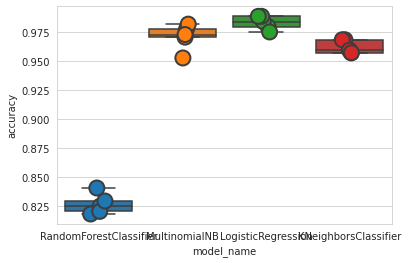

In [ ]:
# Store the entries into the results dataframe and name its columns    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=15, jitter=True, edgecolor="gray", linewidth=2)

In [ ]:
cv_df.groupby('model_name').accuracy.mean()


model_name
KNeighborsClassifier      0.962247
LogisticRegression        0.983371
MultinomialNB             0.971236
RandomForestClassifier    0.826517
Name: accuracy, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split

model = LogisticRegression()

#Split Data 
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, bbc.index, test_size=0.33, random_state=0)

#Train Algorithm
model.fit(X_train, y_train)

# Make Predictions
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

In [ ]:
print('accuracy:', accuracy_score(y_test, y_pred))
print('confusion matrix:\n', confusion_matrix(y_test, y_pred))
print('classification report:\n', classification_report(y_test, y_pred))

accuracy: 0.9795918367346939
confusion matrix:
 [[128   1   0   0   1]
 [  1 161   0   0   6]
 [  0   0 190   0   0]
 [  0   1   0 121   1]
 [  1   1   1   1 120]]
classification report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       130
           1       0.98      0.96      0.97       168
           2       0.99      1.00      1.00       190
           3       0.99      0.98      0.99       123
           4       0.94      0.97      0.95       124

    accuracy                           0.98       735
   macro avg       0.98      0.98      0.98       735
weighted avg       0.98      0.98      0.98       735

